In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipkinc, ellipj

M = 1

In [ ]:
def get_gamma(alpha, theta):
    alpha, theta = np.deg2rad(alpha), np.deg2rad(theta)

    if theta == 0:
        return np.pi/2

    return np.arccos(np.cos(alpha) / np.emath.sqrt(np.cos(alpha)**2 + 1/np.tan(theta)**2))

def get_radius(P, alpha, theta, debug=False):
    assert P >= 3*M, "Closest approach must be greater than 3*M."

    alpha, theta = np.deg2rad(alpha), np.deg2rad(theta)

    Q = np.emath.sqrt((P - 2 * M) * (P + 6 * M))
    gamma = get_gamma(alpha, theta)

    term_1 = (Q - P + 2*M) / (4*M*P)
    term_2 = (Q - P + 6*M) / (4*M*P)

    k_squared = (Q - P + 6*M) / (2*Q)

    sin_squared_zeta = (Q - P + 2*M) / (Q - P + 6*M)
    zeta = np.arcsin(np.emath.sqrt(sin_squared_zeta))

    F = ellipkinc(zeta, k_squared)
    u = gamma/2 * np.emath.sqrt(P/Q) + F
    sn, _, _, _ = ellipj(u, k_squared)

    if debug:
        print(f"Q: {Q}")
        print(f"gamma: {gamma}")
        print(f"term_1: {term_1}")
        print(f"term_2: {term_2}")
        print(f"k^2: {k_squared}")
        print(f"zeta: {zeta}")
        print(f"F: {F}")
        print(f"u: {u}")   
        print(f"sn: {sn}")

    return 1 / (-term_1 + term_2 * sn**2)

def get_impact_parameter(P):
    return P**3 / (P - 2*M)

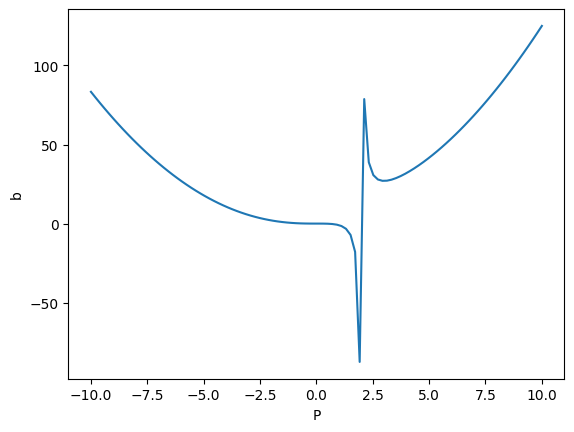

In [273]:
x = np.linspace(-10*M, 10*M, 100)

plt.plot(
    x,
    get_impact_parameter(x),
)


plt.xlabel('P')
plt.ylabel('b')
plt.show()




\begin{align*}
	b &= \frac{P^3}{P-2M}\\
	bP - 2Mb &= P^3\\
	P^3 - bP + 2Mb &=0.
\end{align*}

-b/((-1/2 - sqrt(3)*I/2)*(27*M*b + sqrt(2916*M**2*b**2 - 108*b**3)/2)**(1/3)) - (-1/2 - sqrt(3)*I/2)*(27*M*b + sqrt(2916*M**2*b**2 - 108*b**3)/2)**(1/3)/3


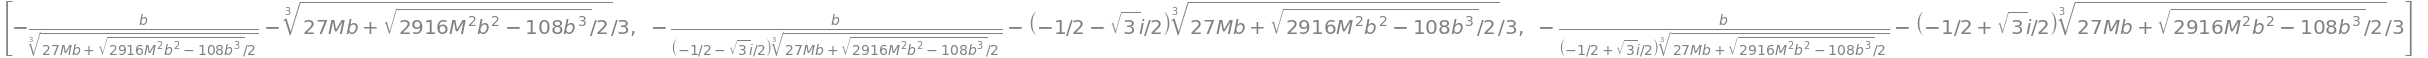

In [15]:
# solve get_impact_parameter for P
import sympy as sp
# sp.init_printing()

sp_P, sp_b, sp_M = sp.symbols("P b M")

eq = sp_P**3 - sp_b * sp_P + 2 * sp_M * sp_b

solutions = sp.solve(eq, sp_P)
print(solutions[1])
solutions

In [255]:
def P1(b,M):
    return -b/(27*M*b + np.emath.sqrt(2916*M**2*b**2 - 108*b**3)/2)**(1/3) - (27*M*b + np.emath.sqrt(2916*M**2*b**2 - 108*b**3)/2)**(1/3)/3

def P2(b,M):
    vals = -b/((-1/2 - np.emath.sqrt(3)*1j/2)*(27*M*b + np.emath.sqrt(2916*M**2*b**2 - 108*b**3)/2)**(1/3)) - (-1/2 - np.emath.sqrt(3)*1j/2)*(27*M*b + np.emath.sqrt(2916*M**2*b**2 - 108*b**3)/2)**(1/3)/3
    return [np.nan if not np.allclose(np.imag(val),0,1e-60) else np.real(val) for val in vals ]
    
def P3(b,M):
    vals = -b/((-1/2 + np.emath.sqrt(3)*1j/2)*(27*M*b + np.emath.sqrt(2916*M**2*b**2 - 108*b**3)/2)**(1/3)) - (-1/2 + np.emath.sqrt(3)*1j/2)*(27*M*b + np.emath.sqrt(2916*M**2*b**2 - 108*b**3)/2)**(1/3)/3
    return [np.nan if not np.allclose(np.imag(val),0,1e-60) else np.real(val) for val in vals ]

/home/koen/school/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/koen/school/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


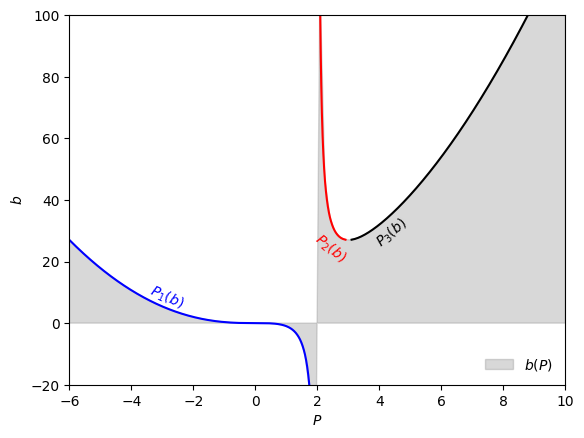

In [274]:
b = np.linspace(-20, 100, 1000)

plt.plot(P1(b, 1), b, c='blue',linewidth=1.5)
plt.plot(P2(b, 1), b, c='red',linewidth=1.5)
plt.plot(P3(b, 1), b, c='k',linewidth=1.5)

plt.text(-3.5,5,r'$P_1(b)$',rotation=-25, color='blue')
plt.text(1.8,20,r'$P_2(b)$',rotation=-40, color='red')
plt.text(3.8,25,r'$P_3(b)$',rotation= 40)

P = np.linspace(-6*M, 10*M, 100)
# plt.plot(P,get_impact_parameter(P),linestyle = (0,(0.1,2)),c='white',linewidth=2.5,dash_capstyle = 'round')
plt.fill_between(P,get_impact_parameter(P),0,color='gray',alpha=0.3,label=r'$b(P)$')

plt.legend(frameon=False,loc='lower right')
plt.ylim(-20, 100)
plt.xlim(-6,10)
plt.xlabel(r'$P$')
plt.ylabel(r'$b$')
plt.show()

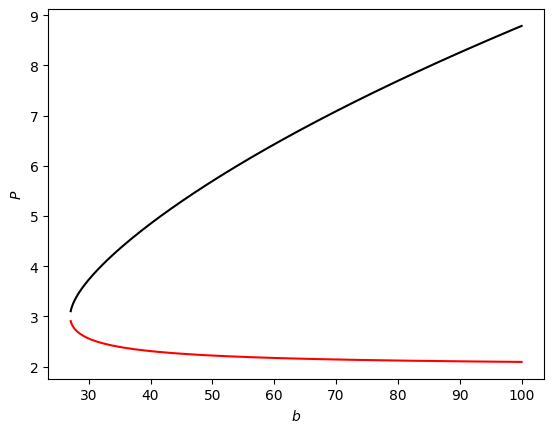

In [275]:
plt.plot(b, P2(b,1),c='r')
plt.plot(b, P3(b,1),c='k')

plt.xlabel(r'$b$')
plt.ylabel(r'$P$')
plt.show()